In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [3]:
# Load datasets
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

# Basic info about the files
print("Train Transaction shape:", train_transaction.shape)
print("Train Identity shape:", train_identity.shape)
print("Test Transaction shape:", test_transaction.shape)
print("Test Identity shape:", test_identity.shape)

# Preview the data
print(train_transaction.head())
print(train_identity.head())

# See all the columns
print(train_transaction.columns)
print(train_identity.columns)

Train Transaction shape: (590540, 394)
Train Identity shape: (144233, 41)
Test Transaction shape: (506691, 393)
Test Identity shape: (141907, 41)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514

In [4]:
# Check missing values
print(train_transaction.isnull().mean().sort_values(ascending=False))
print(train_identity.isnull().mean().sort_values(ascending=False))

# Check constant columns (same value everywhere)
constant_cols_trans = [col for col in train_transaction.columns if train_transaction[col].nunique() <= 1]
constant_cols_id    = [col for col in train_identity.columns if train_identity[col].nunique() <= 1]
print("Constant columns in transaction:", constant_cols_trans)
print("Constant columns in identity:", constant_cols_id)

dist2             0.936284
D7                0.934099
D13               0.895093
D14               0.894695
D12               0.890410
                    ...   
ProductCD         0.000000
TransactionAmt    0.000000
TransactionDT     0.000000
isFraud           0.000000
TransactionID     0.000000
Length: 394, dtype: float64
id_24            0.967088
id_25            0.964419
id_07            0.964259
id_08            0.964259
id_21            0.964231
id_26            0.964204
id_23            0.964162
id_27            0.964162
id_22            0.964162
id_18            0.687221
id_04            0.540161
id_03            0.540161
id_33            0.491871
id_10            0.480521
id_09            0.480521
id_30            0.462224
id_32            0.462079
id_34            0.460560
id_14            0.445037
DeviceInfo       0.177262
id_13            0.117262
id_16            0.103257
id_06            0.051084
id_05            0.051084
id_20            0.034472
id_19            0.034077

In [5]:
# combine transaction with the identity 
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [6]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
#del train_identity, train_transaction, test_identity, test_transaction
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]
one_value_cols == one_value_cols_test

False

In [10]:
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [11]:
print(one_value_cols_test)

['V107']


In [12]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')

There are 414 columns in train dataset with missing values.


In [13]:
print(train.isnull().mean().sort_values(ascending=False))

# Check target balance
print(train['isFraud'].value_counts(normalize=True))

id_24            0.991962
id_25            0.991310
id_07            0.991271
id_08            0.991271
id_21            0.991264
                   ...   
C11              0.000000
C14              0.000000
C13              0.000000
C12              0.000000
TransactionID    0.000000
Length: 434, dtype: float64
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


EDA

Target variable visualization

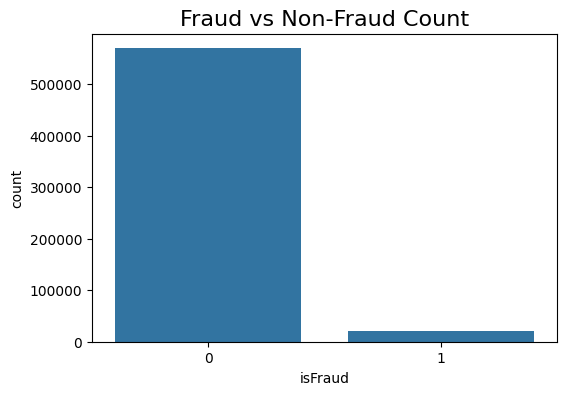

Fraud Rate: 3.50%


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count plot
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=train)
plt.title("Fraud vs Non-Fraud Count", fontsize=16)
plt.show()

# Percentage
fraud_rate = train['isFraud'].mean() * 100
print(f"Fraud Rate: {fraud_rate:.2f}%")

Missing values visualization

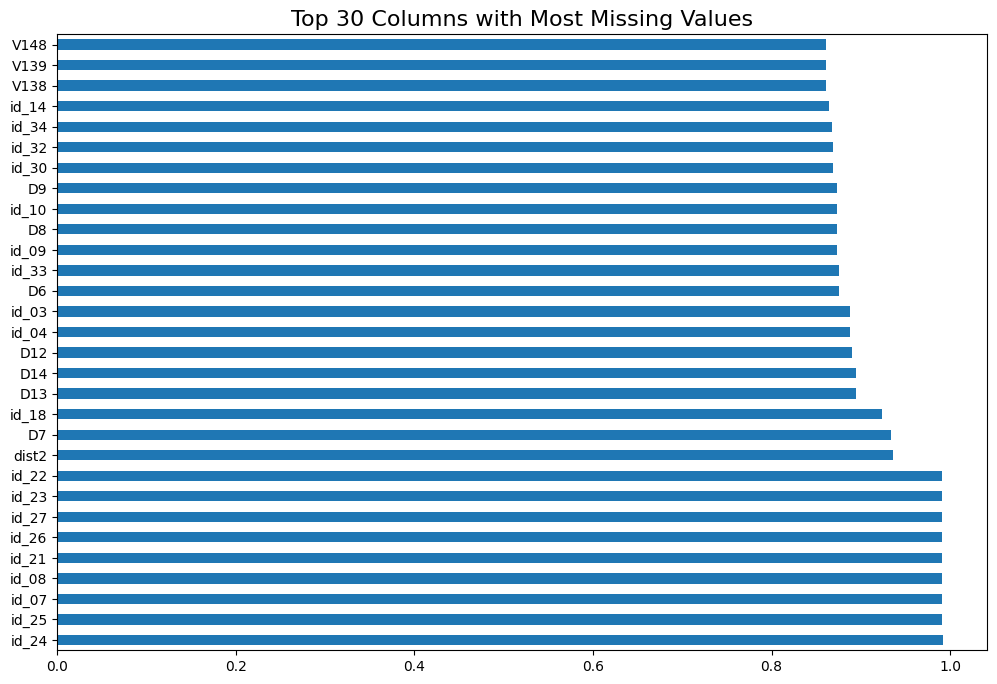

Columns with >90% missing: ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
✅ New train shape: (590540, 422)
✅ New test shape: (506691, 431)


In [15]:
# Step 1: Show missing values
missing_values = train.isnull().mean().sort_values(ascending=False)

# Step 2: Plot top 30 missing
missing_values.head(30).plot(kind='barh', figsize=(12,8))
plt.title("Top 30 Columns with Most Missing Values", fontsize=16)
plt.show()

# Step 3: List columns with >90% missing
high_missing_cols = train.columns[train.isnull().mean() > 0.90]
print("Columns with >90% missing:", list(high_missing_cols))

# Step 4: Drop those columns
train.drop(columns=high_missing_cols, inplace=True)
test.drop(columns=high_missing_cols, inplace=True, errors='ignore')  # <-- safer with errors='ignore'

print(f"✅ New train shape: {train.shape}")
print(f"✅ New test shape: {test.shape}")

Categorical features exploration

In [16]:
charts = {}
for i in ['ProductCD', 'card4', 'card6', 'M4', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    feature_count = train[i].value_counts(dropna=False).reset_index()
    feature_count.columns = [i, 'count']  # Correctly name the columns
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=400)
    charts[i] = chart

display(
    (charts['ProductCD'] | charts['card4']) &
    (charts['card6'] | charts['M4']) &
    (charts['M1'] | charts['M2']) &
    (charts['M3'] | charts['M5']) &
    (charts['M6'] | charts['M7']) &
    (charts['M8'] | charts['M9'])
)

alt.VConcatChart(...)

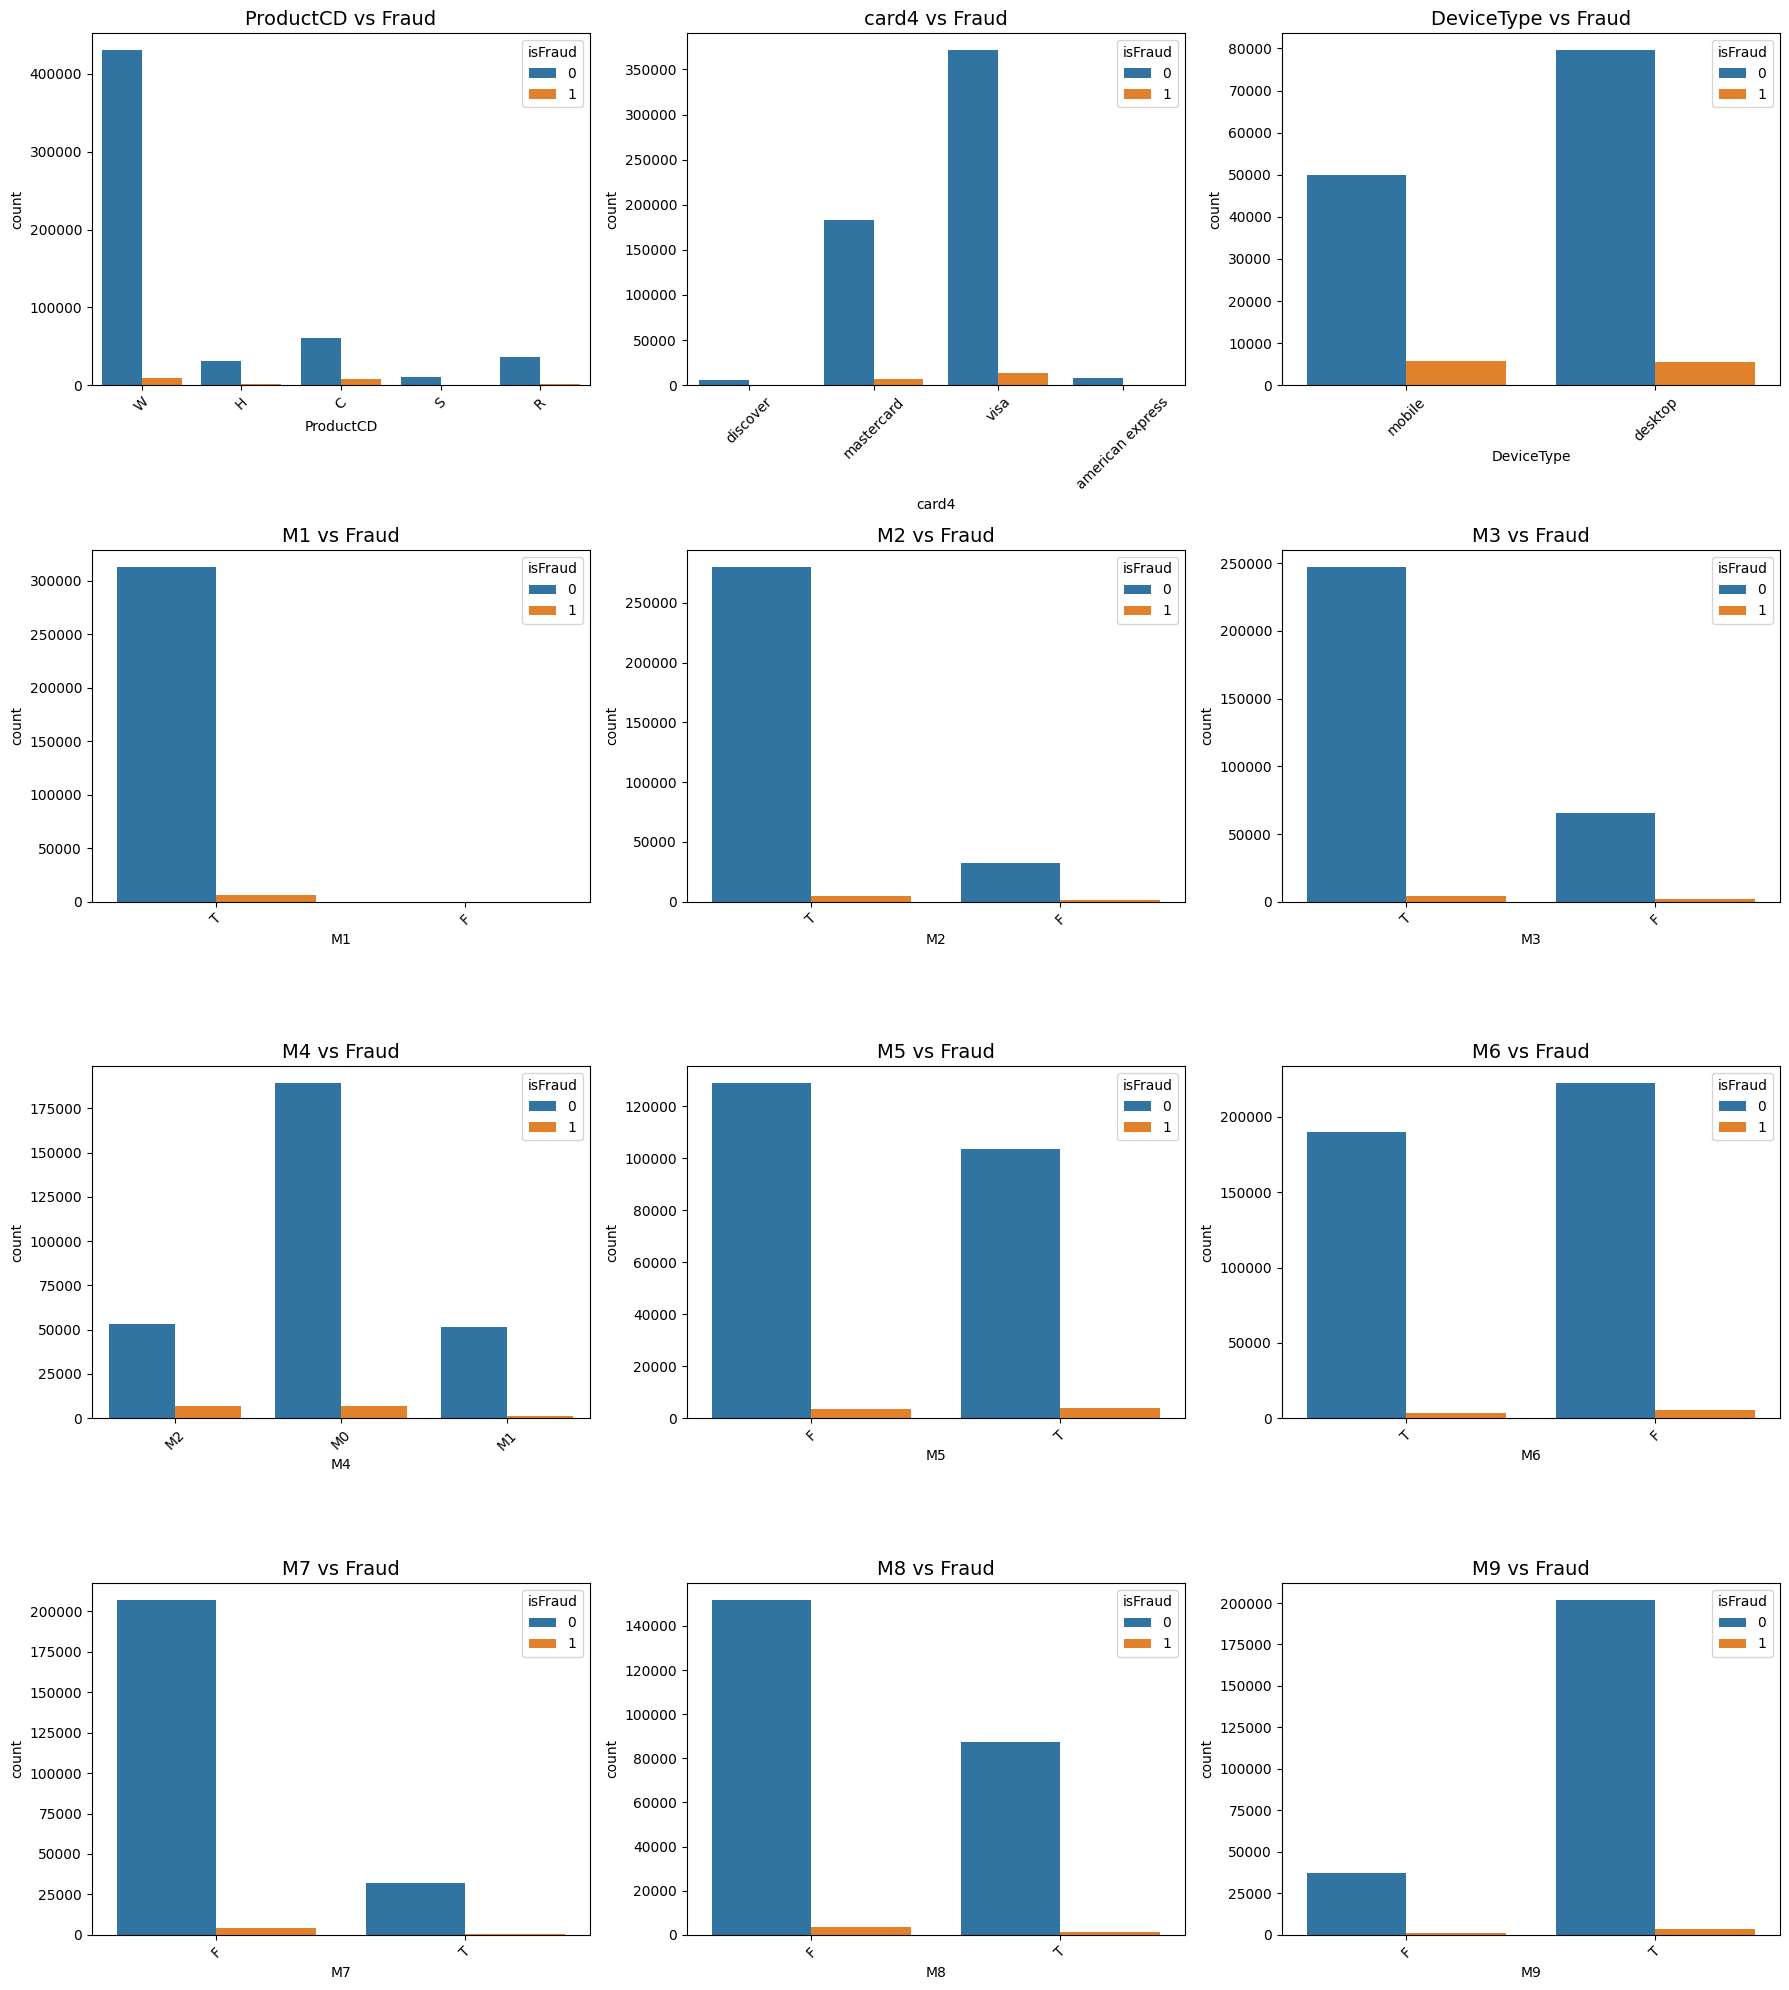

In [17]:
# Features to plot
features = ['ProductCD', 'card4', 'DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Set up the grid: 3 columns
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols  # automatically calculate number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))  # adjust figsize based on rows

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through features
for i, feature in enumerate(features):
    sns.countplot(x=feature, hue='isFraud', data=train, ax=axes[i])
    axes[i].set_title(f"{feature} vs Fraud", fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)  # rotate if needed

# Turn off empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [18]:
for feature in ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']:
    print(f"Top values for {feature}:")
    print(train[feature].value_counts(dropna=False).head(10))
    print('-'*50)

Top values for P_emaildomain:
P_emaildomain
gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6267
outlook.com        5096
msn.com            4092
Name: count, dtype: int64
--------------------------------------------------
Top values for R_emaildomain:
R_emaildomain
NaN              453249
gmail.com         57147
hotmail.com       27509
anonymous.com     20529
yahoo.com         11842
aol.com            3701
outlook.com        2507
comcast.net        1812
yahoo.com.mx       1508
icloud.com         1398
Name: count, dtype: int64
--------------------------------------------------
Top values for card1:
card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
12695     7091
12544     6773
6019      6771
2803      6141
7585      5334
Name: count, dtype: int64
--------------------------------------------------
Top values for card2:
c

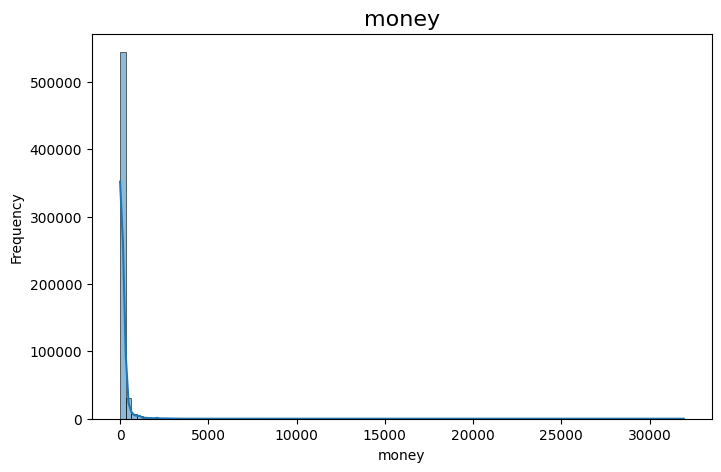

In [67]:
plt.figure(figsize=(8,5))
sns.histplot(train['TransactionAmt'], bins=100, kde=True)
plt.title("money", fontsize=16)
plt.xlabel("money")
plt.ylabel("Frequency")
plt.show()

In [19]:
charts = {}

for i in ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']:
    feature_count = train[i].value_counts(dropna=False).reset_index()[:40]
    feature_count.columns = [i, 'count']  # properly name columns
    chart = alt.Chart(feature_count).mark_bar().encode(
        x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
        y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
        tooltip=[i, 'count']
    ).properties(
        title=f"Counts of {i}",
        width=600
    )
    charts[i] = chart
    
display(
    (charts['P_emaildomain'] | charts['R_emaildomain']) &
    (charts['card1'] | charts['card2']) &
    (charts['card3'] | charts['card5']) &
    (charts['addr1'] | charts['addr2'])
)

alt.VConcatChart(...)

Numerical features exploration

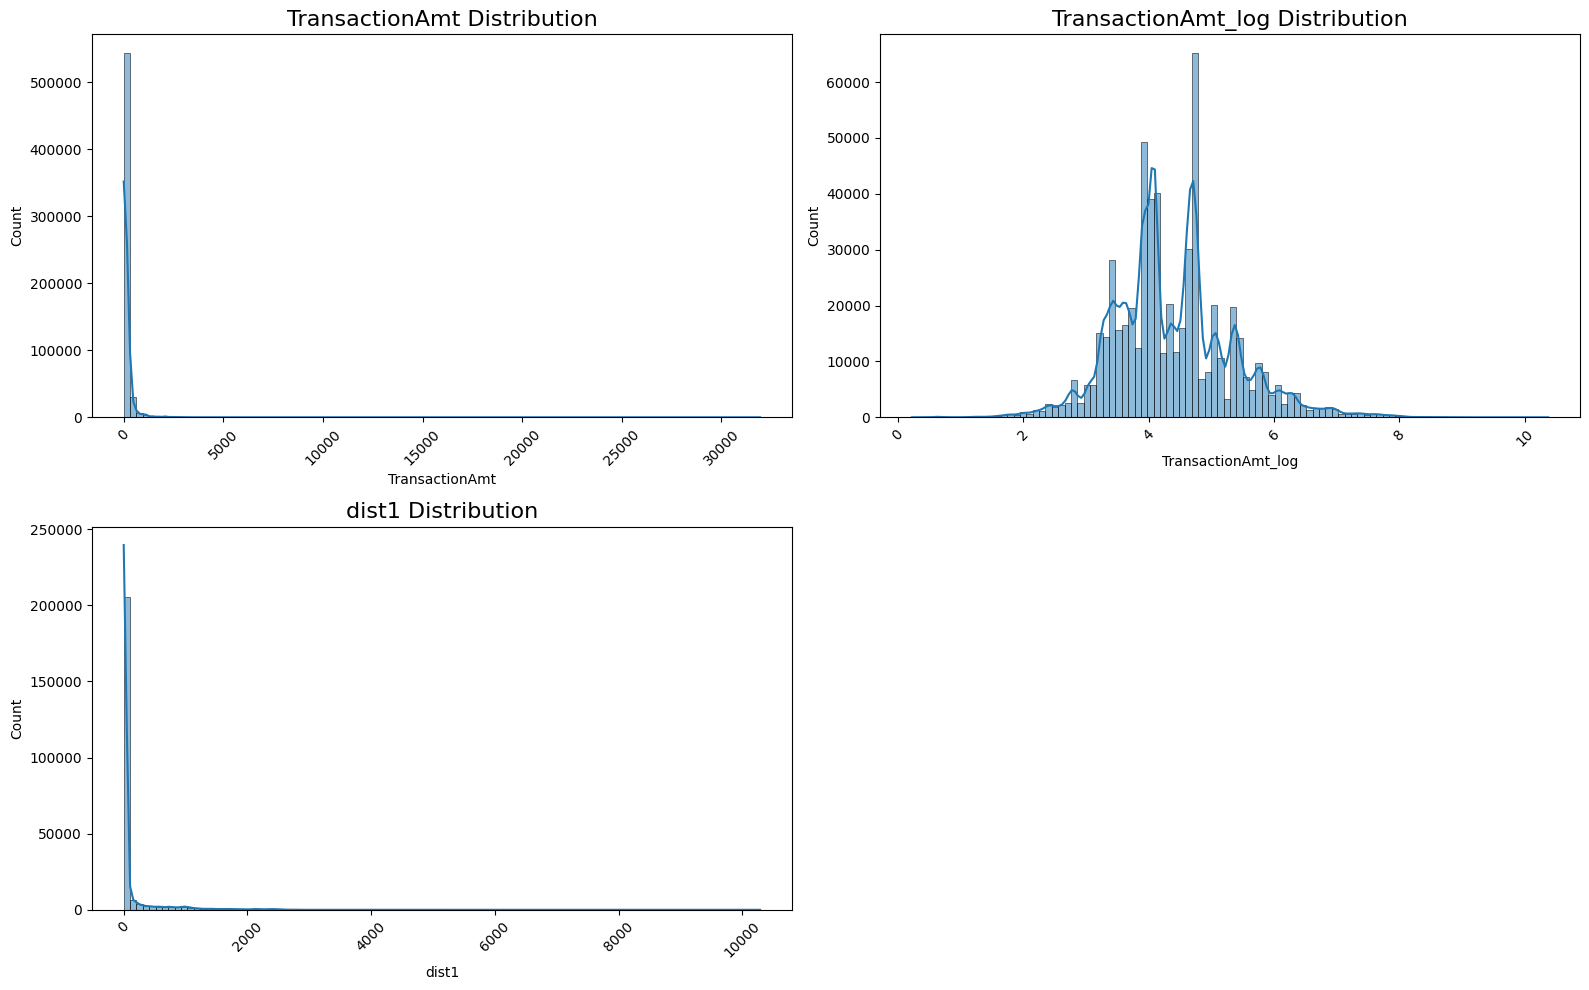

In [20]:
# Add log-transformed amount safely
train['TransactionAmt_log'] = np.log1p(train['TransactionAmt']) if 'TransactionAmt_log' not in train.columns else train['TransactionAmt_log']

# Features you want to plot
num_features = ['TransactionAmt', 'TransactionAmt_log', 'dist1', 'dist2']

# Set grid size dynamically
n_cols = 2
n_rows = (len(num_features) + n_cols - 1) // n_cols  # auto-calculate number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten()

# Plot each feature
for idx, feature in enumerate(num_features):
    if feature in train.columns:
        sns.histplot(train[feature], bins=100, kde=True, ax=axes[idx])
        axes[idx].set_title(f"{feature} Distribution", fontsize=16)
        axes[idx].tick_params(axis='x', rotation=45)
    else:
        axes[idx].set_visible(False)

# Tidy layout
plt.tight_layout()
plt.show()

Correlation and feature importance

Top correlated features with isFraud:
isFraud    1.000000
V257       0.383060
V246       0.366878
V244       0.364129
V242       0.360590
V201       0.328005
V200       0.318783
V189       0.308219
V188       0.303582
V258       0.297151
V45        0.281832
V158       0.278066
V156       0.275952
V149       0.273282
V228       0.268861
V44        0.260376
V86        0.251828
V87        0.251737
V170       0.249794
V147       0.242894
Name: isFraud, dtype: float64
D5      -0.064638
D1      -0.067193
D4      -0.067216
V36     -0.069875
V11     -0.071950
D10     -0.072002
V10     -0.074658
V35     -0.077116
D15     -0.077519
D2      -0.083583
V70     -0.100900
V30     -0.103088
V69     -0.104521
V91     -0.105453
V29     -0.107852
V90     -0.110168
V49     -0.110920
V48     -0.115786
id_01   -0.120099
D8      -0.142636
Name: isFraud, dtype: float64


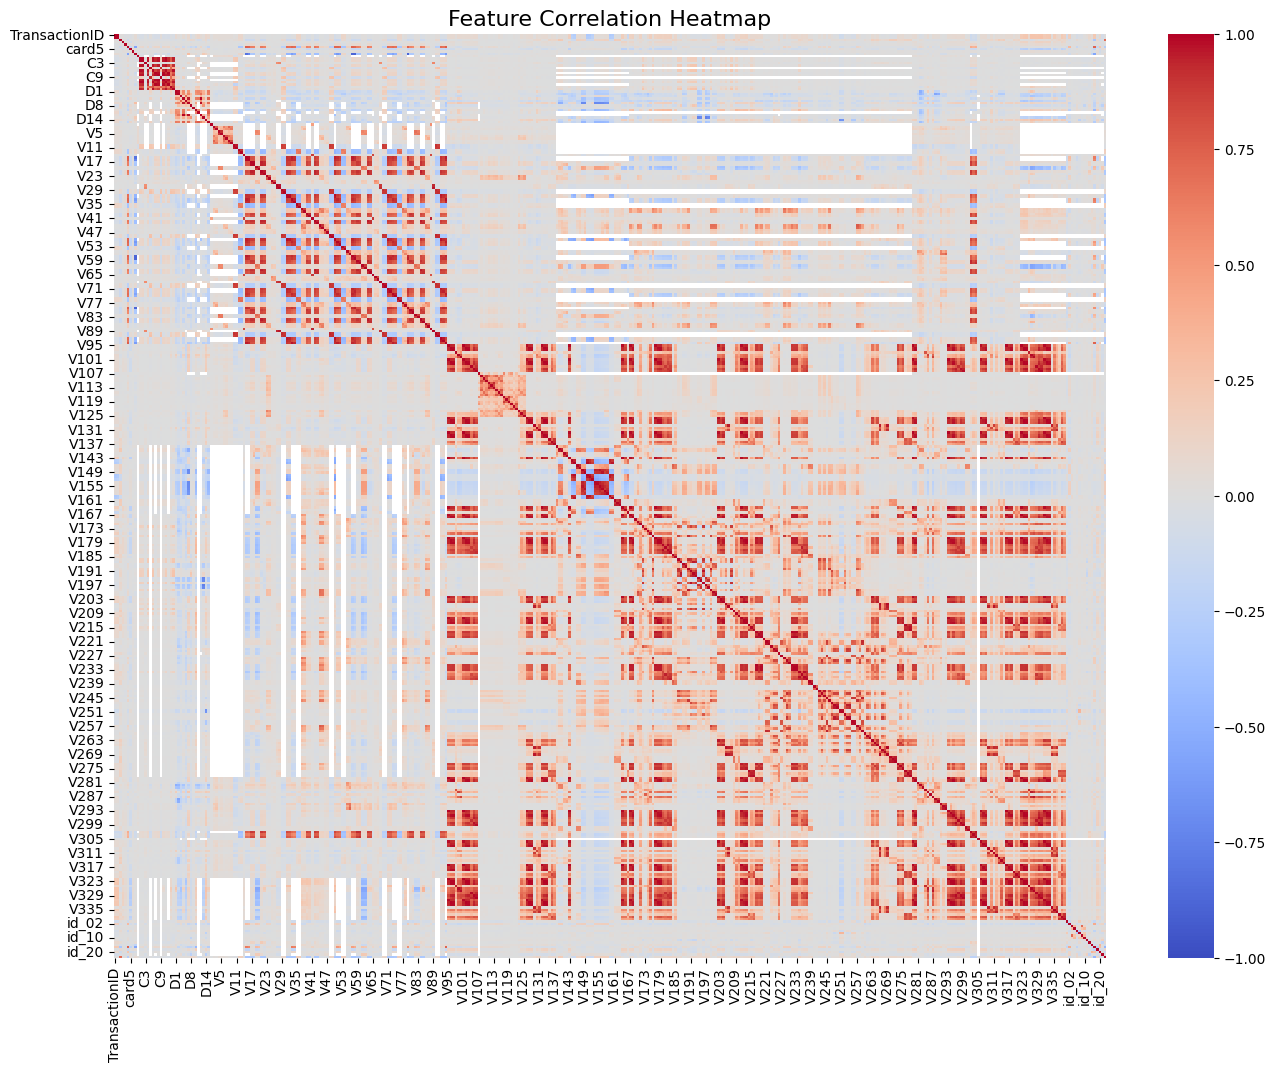

In [21]:
# Correlation with target (only numerics)
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('isFraud')

corr = train[numerical_cols + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

print("Top correlated features with isFraud:")
print(corr.head(20))  # top positive
print(corr.tail(20))  # top negative

# Correlation heatmap
plt.figure(figsize=(16,12))
sns.heatmap(train[numerical_cols].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

Heatmap with just the top 20 positive/negative correlated features

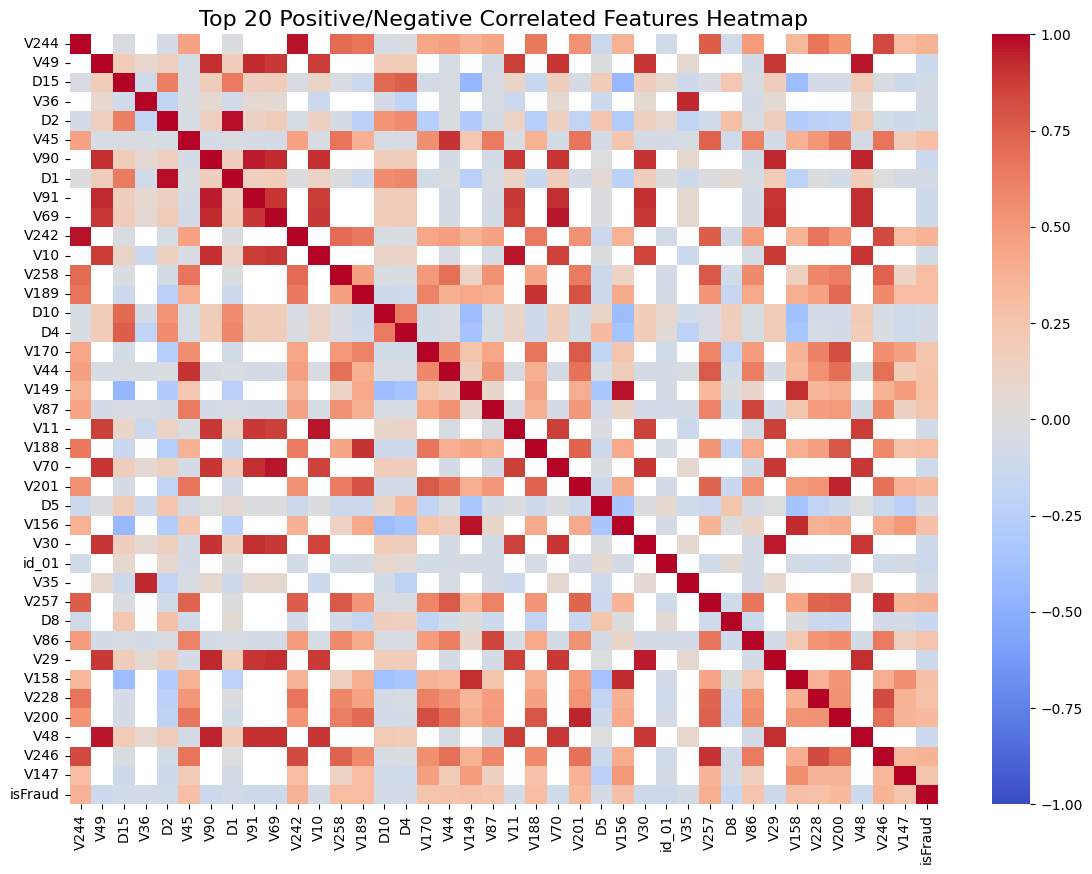

In [22]:
top_features = corr.index[:20].tolist() + corr.index[-20:].tolist()  # top and bottom 20
top_features = list(set(top_features))  # remove duplicates

plt.figure(figsize=(14,10))
sns.heatmap(train[top_features].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title("Top 20 Positive/Negative Correlated Features Heatmap", fontsize=16)
plt.show()

Text(0.5, 1.0, 'Distribution of transaction dates')

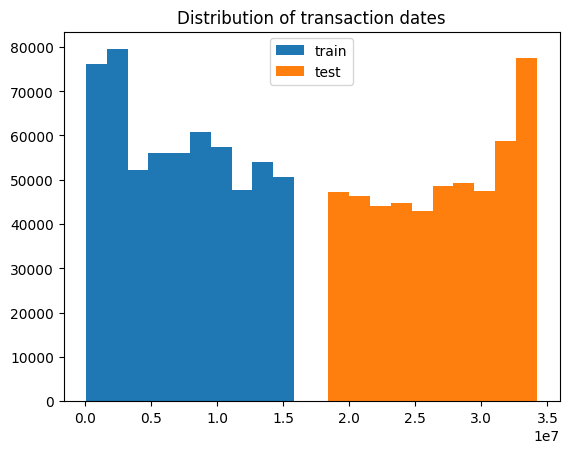

In [23]:
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of transaction dates')

Feature Engineering

In [24]:
# Check columns with more than 90% missing values
missing_percent = train.isnull().mean() * 100  # percent missing
high_missing_cols = missing_percent[missing_percent > 90]

# Display them
if high_missing_cols.empty:
    print("No columns with >90% missing values remain.")
else:
    print("Columns with >90% missing values still present:")
    print(high_missing_cols)

No columns with >90% missing values remain.


In [25]:
# Drop from train
#train.drop(columns=high_missing_cols, inplace=True, errors='ignore')

# Drop from test 
#test.drop(columns=high_missing_cols, inplace=True, errors='ignore')
# Check how many columns are remaining in train and test
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Recalculate missing values after drop
missing_after_drop = train.isnull().mean().sort_values(ascending=False)

# Print top 20 columns with missing values remaining
print("Top 20 columns still having missing values (after dropping high-missing ones):")
print(missing_after_drop.head(20))

# Check if any column still has >90% missing
high_missing_after_drop = missing_after_drop[missing_after_drop > 0.90]

print(f"\nColumns still with >90% missing after drop: {list(high_missing_after_drop.index)}")

Train shape: (590540, 423)
Test shape: (506691, 431)
Top 20 columns still having missing values (after dropping high-missing ones):
D13      0.895093
D14      0.894695
D12      0.890410
id_03    0.887689
id_04    0.887689
D6       0.876068
id_33    0.875895
id_09    0.873123
D8       0.873123
D9       0.873123
id_10    0.873123
id_30    0.868654
id_32    0.868619
id_34    0.868248
id_14    0.864456
V147     0.861237
V149     0.861237
V148     0.861237
V158     0.861237
V156     0.861237
dtype: float64

Columns still with >90% missing after drop: []


Handle the missing values

In [26]:
# Fill missing values for numeric columns
numeric_cols = train.select_dtypes(include=[np.number]).columns

# Only use numeric columns that exist in both train and test
numeric_cols_existing = [col for col in numeric_cols if col in test.columns]

train[numeric_cols] = train[numeric_cols].fillna(-1)
test[numeric_cols_existing] = test[numeric_cols_existing].fillna(-1)

# Fill missing values for object (categorical) columns
categorical_cols = train.select_dtypes(include=['object']).columns
categorical_cols_existing = [col for col in categorical_cols if col in test.columns]

train[categorical_cols] = train[categorical_cols].fillna('missing')
test[categorical_cols_existing] = test[categorical_cols_existing].fillna('missing')

In [27]:
print("✅ No missing values left in train!") if train.isnull().sum().sum() == 0 else print("⚠️ Still missing values in train.")

print("✅ No missing values left in test!") if test.isnull().sum().sum() == 0 else print("⚠️ Still missing values in test.")

✅ No missing values left in train!
⚠️ Still missing values in test.


In [28]:
# Find columns with missing values in test
missing_in_test = test.columns[test.isnull().any()].tolist()
print("Columns still with missing in test:", missing_in_test)

Columns still with missing in test: ['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']


In [29]:
# Fill missing numeric columns with -1
for col in missing_in_test:
    if test[col].dtype in ['float64', 'int64']:
        test[col] = test[col].fillna(-1)
    else:
        test[col] = test[col].fillna('missing')

In [30]:
print("✅ No missing values left in test!") if test.isnull().sum().sum() == 0 else print("⚠️ Still missing values in test.")

✅ No missing values left in test!


Label encoding for categorical values

In [31]:
# Find categorical columns in train
categorical_cols = train.select_dtypes(include=['object']).columns

# Loop through each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    
    if col in test.columns:  # Only if column exists in both train and test
        combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
        le.fit(combined_data)
        
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))
        
    else:  # If column only exists in train, just encode train
        train[col] = le.fit_transform(train[col].astype(str))

In [32]:
for feature in ['id_03', 'id_04', 'id_30', 'id_31', 'id_32', 'id_09', 'id_10']:
    print(f"{feature}: {train[feature].nunique()} unique values")

id_03: 24 unique values
id_04: 15 unique values
id_30: 76 unique values
id_31: 131 unique values
id_32: 5 unique values
id_09: 46 unique values
id_10: 62 unique values


Create time features from the transaction

In [33]:
# Create 'TransactionDT_days' to represent how many days passed
train['TransactionDT_days'] = train['TransactionDT'] / (24 * 60 * 60)
test['TransactionDT_days'] = test['TransactionDT'] / (24 * 60 * 60)

# Create 'hour' feature
train['Transaction_hour'] = ((train['TransactionDT'] / 3600) % 24).astype(int)
test['Transaction_hour'] = ((test['TransactionDT'] / 3600) % 24).astype(int)

# Create 'weekday' feature
train['Transaction_weekday'] = ((train['TransactionDT'] / (3600*24)) % 7).astype(int)
test['Transaction_weekday'] = ((test['TransactionDT'] / (3600*24)) % 7).astype(int)

# Create 'is_weekend' feature
train['is_weekend'] = (train['Transaction_weekday'] >=5).astype(int)
test['is_weekend'] = (test['Transaction_weekday'] >=5).astype(int)

C:\Users\27611\AppData\Local\Temp\ipykernel_14896\2804737187.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['TransactionDT_days'] = train['TransactionDT'] / (24 * 60 * 60)
C:\Users\27611\AppData\Local\Temp\ipykernel_14896\2804737187.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['TransactionDT_days'] = test['TransactionDT'] / (24 * 60 * 60)
C:\Users\27611\AppData\Local\Temp\ipykernel_14896\2804737187.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

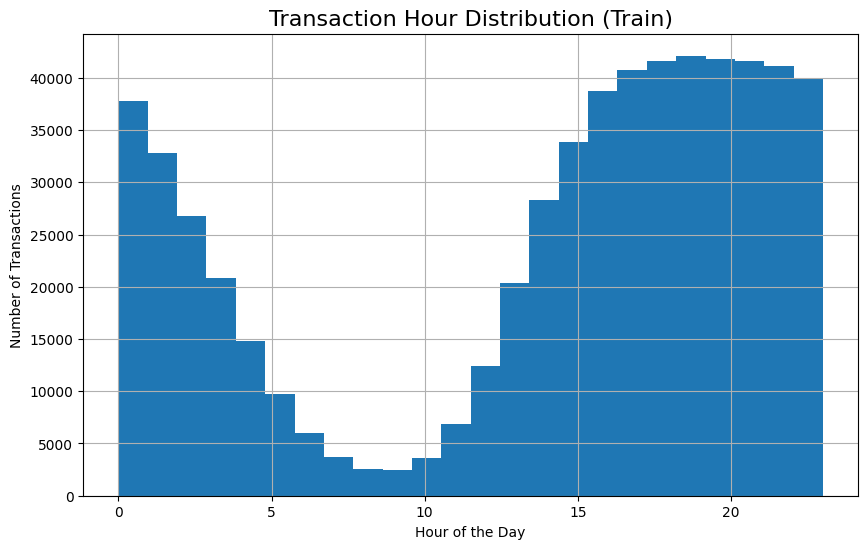

In [34]:
plt.figure(figsize=(10,6))
train['Transaction_hour'].hist(bins=24)
plt.title('Transaction Hour Distribution (Train)', fontsize=16)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Transactions')
plt.show()

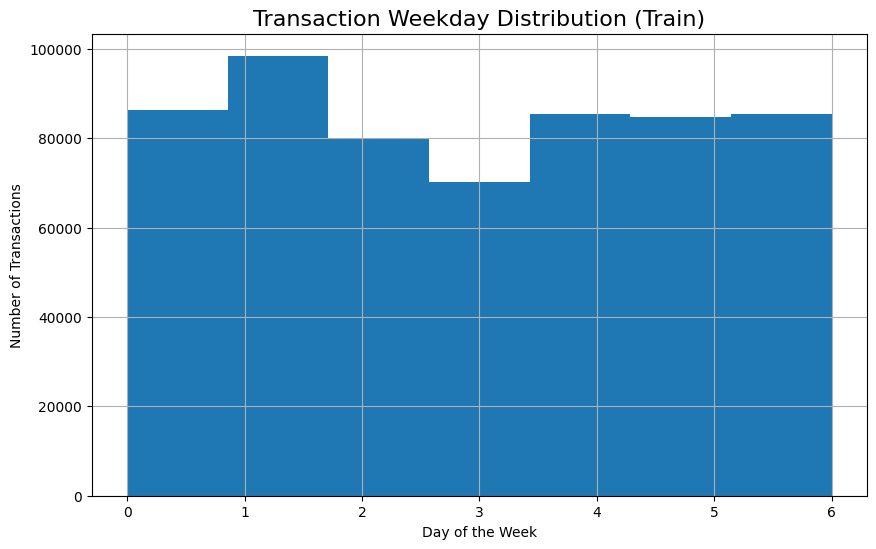

In [35]:
plt.figure(figsize=(10,6))
train['Transaction_weekday'].hist(bins=7)
plt.title('Transaction Weekday Distribution (Train)', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.show()

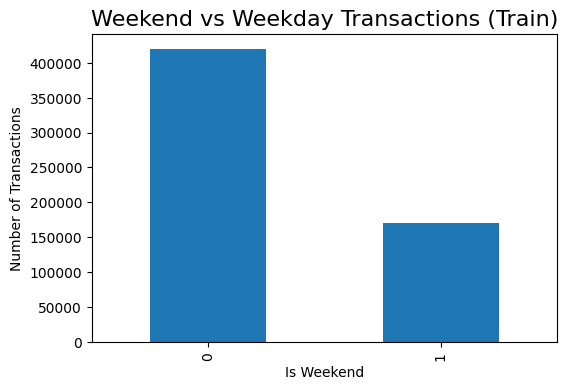

In [36]:
plt.figure(figsize=(6,4))
train['is_weekend'].value_counts().plot(kind='bar')
plt.title('Weekend vs Weekday Transactions (Train)', fontsize=16)
plt.xlabel('Is Weekend')
plt.ylabel('Number of Transactions')
plt.show()

In [37]:
# See which categories will be grouped for each feature
for col in ['DeviceType', 'card4']:
    freq = train[col].value_counts()
    rare_cats = freq[freq < 1000].index
    print(f"Feature: {col}")
    print(f"Categories to be replaced with 'Rare': {list(rare_cats)}")
    print('-'*50)

Feature: DeviceType
Categories to be replaced with 'Rare': []
--------------------------------------------------
Feature: card4
Categories to be replaced with 'Rare': []
--------------------------------------------------


In [39]:
# Find features with too many unique values
for col in ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'id_34', 'card1', 'card2', 'card5']:
    print(f"{col}: {train[col].nunique()} unique values")

P_emaildomain: 60 unique values
R_emaildomain: 61 unique values
id_30: 76 unique values
id_31: 131 unique values
id_33: 261 unique values
id_34: 5 unique values
card1: 13553 unique values
card2: 501 unique values
card5: 120 unique values


Creating frequency encoder for Card1

In [42]:
card1_freq = train['card1'].value_counts()
train['card1_freq'] = train['card1'].map(card1_freq)
test['card1_freq'] = test['card1'].map(card1_freq)

In [43]:
# Group rare categories 
# Features to group rare categories
grouping_features = ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'card2', 'card5']

for col in grouping_features:
    freq = train[col].value_counts()
    rare_cats = freq[freq < 500].index  # you can adjust 500 based on how strict you want
    train[col] = train[col].replace(rare_cats, 'Rare')
    if col in test.columns:
        test[col] = test[col].replace(rare_cats, 'Rare')
print("Rare categories grouped.")

# Create transaction amount ratios 
for col in ['card1', 'card4']:
    train[f'TransactionAmt_to_mean_{col}'] = train['TransactionAmt'] / train.groupby(col)['TransactionAmt'].transform('mean')
    test[f'TransactionAmt_to_mean_{col}'] = test['TransactionAmt'] / test.groupby(col)['TransactionAmt'].transform('mean')

    train[f'TransactionAmt_to_std_{col}'] = train['TransactionAmt'] / train.groupby(col)['TransactionAmt'].transform('std')
    test[f'TransactionAmt_to_std_{col}'] = test['TransactionAmt'] / test.groupby(col)['TransactionAmt'].transform('std')

print("Transaction amount ratio features created.")

# Create "is_nighttime" Feature 
train['is_nighttime'] = ((train['Transaction_hour'] >= 0) & (train['Transaction_hour'] <= 5)).astype(int)
test['is_nighttime'] = ((test['Transaction_hour'] >= 0) & (test['Transaction_hour'] <= 5)).astype(int)

print("Nighttime feature created.")

# Preserve transactionID for later
test_transaction_id = test['TransactionID'].copy()

# Drop TransactionID 
drop_cols = ['TransactionID']
train.drop(columns=[col for col in drop_cols if col in train.columns], inplace=True)
test.drop(columns=[col for col in drop_cols if col in test.columns], inplace=True)

print("Dropped useless columns.")

# Final Check 
print(f"Train shape after feature engineering: {train.shape}")
print(f"Test shape after feature engineering: {test.shape}")

Rare categories grouped.
Transaction amount ratio features created.
Nighttime feature created.


C:\Users\27611\AppData\Local\Temp\ipykernel_14896\168492883.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[f'TransactionAmt_to_mean_{col}'] = train['TransactionAmt'] / train.groupby(col)['TransactionAmt'].transform('mean')
C:\Users\27611\AppData\Local\Temp\ipykernel_14896\168492883.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'TransactionAmt_to_mean_{col}'] = test['TransactionAmt'] / test.groupby(col)['TransactionAmt'].transform('mean')
C:\Users\27611\AppData\Local\Temp\ipykernel_14896\168492883.py:18: 

Dropped useless columns.
Train shape after feature engineering: (590540, 432)
Test shape after feature engineering: (506691, 440)


The difference train/test columns

In [44]:
print("Columns in test but not in train:", set(test.columns) - set(train.columns))
print("Columns in train but not in test:", set(train.columns) - set(test.columns))

Columns in test but not in train: {'id-36', 'id-19', 'id-17', 'id-11', 'id-31', 'id-02', 'id-34', 'id-03', 'id-20', 'id-28', 'id-38', 'id-15', 'id-33', 'id-06', 'id-27', 'id-12', 'id-09', 'id-16', 'id-30', 'id-08', 'id-05', 'id-04', 'id-35', 'id-37', 'id-26', 'id-01', 'id-07', 'id-18', 'id-32', 'id-25', 'id-21', 'id-10', 'id-22', 'id-13', 'id-29', 'id-23', 'id-24', 'id-14'}
Columns in train but not in test: {'id_05', 'id_12', 'id_02', 'id_06', 'id_17', 'id_09', 'id_38', 'id_32', 'id_29', 'id_30', 'id_03', 'id_15', 'id_36', 'id_31', 'id_13', 'id_04', 'id_34', 'id_16', 'id_28', 'TransactionAmt_log', 'id_20', 'id_37', 'id_33', 'id_11', 'id_01', 'id_35', 'id_19', 'id_10', 'id_14', 'isFraud'}


In [45]:
# Fix column names in test
test.columns = test.columns.str.replace('-', '_')

In [46]:
print("Columns in test but not in train:", set(test.columns) - set(train.columns))
print("Columns in train but not in test:", set(train.columns) - set(test.columns))

Columns in test but not in train: {'id_25', 'id_21', 'id_23', 'id_07', 'id_08', 'id_26', 'id_22', 'id_27', 'id_24', 'id_18'}
Columns in train but not in test: {'TransactionAmt_log', 'isFraud'}


In [47]:
test[['id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']].describe()

,id_07,id_08,id_18,id_21,id_22,id_24,id_25,id_26
count,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000,506691.000000
mean,-0.865279,-1.355222,0.585992,4.079328,-0.836790,-0.867473,2.312086,0.531488
std,1.777943,4.361818,4.803780,55.446055,1.718998,1.398936,34.150385,15.597135
min,-41.000000,-100.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,59.000000,0.000000,29.000000,854.000000,44.000000,26.000000,549.000000,216.000000


In [48]:
# See missing percentages
missing_test = test[['id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']].isnull().mean() * 100
print(missing_test.sort_values())

id_07    0.0
id_08    0.0
id_18    0.0
id_21    0.0
id_22    0.0
id_23    0.0
id_24    0.0
id_25    0.0
id_26    0.0
id_27    0.0
dtype: float64


In [49]:
# Drop extra ID columns from test
extra_cols_in_test = ['id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
test = test.drop(columns=extra_cols_in_test)

# Create TransactionAmt_log for test set
test['TransactionAmt_log'] = np.log1p(test['TransactionAmt'])

C:\Users\27611\AppData\Local\Temp\ipykernel_14896\1485934099.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['TransactionAmt_log'] = np.log1p(test['TransactionAmt'])


In [50]:
print("Columns in test but not in train:", set(test.columns) - set(train.columns))
print("Columns in train but not in test:", set(train.columns) - set(test.columns))


Columns in test but not in train: set()
Columns in train but not in test: {'isFraud'}


In [51]:
#train = train.copy()
#test = test.copy()
cols_high_missing = ['id_30', 'id_31', 'id_33', 'id_34', 'id_28', 'id_29']
# Check missing values percentage for high-missing columns
missing_percent = train[cols_high_missing].isnull().mean() * 100
print(missing_percent.sort_values())

# Also, basic description (to see weird values)
print(train[cols_high_missing].describe(include='all'))

id_30    0.0
id_31    0.0
id_33    0.0
id_34    0.0
id_28    0.0
id_29    0.0
dtype: float64
           id_30     id_31     id_33          id_34          id_28  \
count   590540.0  590540.0  590540.0  590540.000000  590540.000000   
unique      28.0      33.0      22.0            NaN            NaN   
top         74.0      96.0     260.0            NaN            NaN   
freq    512975.0  450258.0  517251.0            NaN            NaN   
mean         NaN       NaN       NaN       3.837403       1.632184   
std          NaN       NaN       NaN       0.446413       0.700504   
min          NaN       NaN       NaN       0.000000       0.000000   
25%          NaN       NaN       NaN       4.000000       2.000000   
50%          NaN       NaN       NaN       4.000000       2.000000   
75%          NaN       NaN       NaN       4.000000       2.000000   
max          NaN       NaN       NaN       4.000000       2.000000   

                id_29  
count   590540.000000  
unique            

In [52]:
# Drop only id_34 (because it's useless)
train.drop(columns=['id_34'], inplace=True)
test.drop(columns=['id_34'], inplace=True)

In [53]:
# Columns you are checking
low_missing_cols = ['id_12', 'id_15', 'id_16', 'id_35', 'id_36', 'id_37', 'id_38']

# Check data types
for col in low_missing_cols:
    if col in train.columns:
        print(f"{col} - dtype: {train[col].dtype}, unique values: {train[col].nunique()}")

id_12 - dtype: int64, unique values: 3
id_15 - dtype: int64, unique values: 4
id_16 - dtype: int64, unique values: 3
id_35 - dtype: int64, unique values: 3
id_36 - dtype: int64, unique values: 3
id_37 - dtype: int64, unique values: 3
id_38 - dtype: int64, unique values: 3


In [54]:
from sklearn.preprocessing import LabelEncoder

# Columns that are causing problem
cat_cols = ['card2', 'card5', 'P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33']

# Label Encode
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        all_data = pd.concat([train[col], test[col]], axis=0).astype(str)  # Fit on both train and test
        le.fit(all_data)
        train[col] = le.transform(train[col].astype(str))
        test[col] = le.transform(test[col].astype(str))

print("✅ Categorical columns encoded successfully!")

✅ Categorical columns encoded successfully!


In [55]:
train = train.copy()
test = test.copy()

Time-based split

In [56]:
# Define target and features
TARGET = 'isFraud'
features = [col for col in train.columns if col != TARGET]

In [57]:
# Sort by TransactionDT_days for proper time order
train = train.sort_values('TransactionDT_days').reset_index(drop=True)

# Define train/validation split (80% train, 20% validation)
split_index = int(len(train) * 0.8)

X_train = train.iloc[:split_index][features]
y_train = train.iloc[:split_index][TARGET]

X_val = train.iloc[split_index:][features]
y_val = train.iloc[split_index:][TARGET]

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

Train shape: (472432, 430), Validation shape: (118108, 430)


Model training

LIghtGBM

In [60]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Define LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.005,
    'num_leaves': 128,
    'max_depth': -1,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'scale_pos_weight': 20,
    'random_state': 2025,
    'verbose': -1
}

# Prepare X and y
X = train[features]
y = train[TARGET]

# Fix test set object columns before starting
for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = test[col].astype('category').cat.codes

# Stratified K-Fold CV
n_splits = 3
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2025)

# Store out-of-fold predictions
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# Train model on each fold
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n📚 Training fold {fold + 1}...")
    
    X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_set = lgb.Dataset(X_train_cv, label=y_train_cv)
    valid_set = lgb.Dataset(X_valid_cv, label=y_valid_cv)
    
    model = lgb.train(
        lgb_params,
        train_set,
        num_boost_round=5000,
        valid_sets=[train_set, valid_set],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Predictions
    oof_preds[valid_idx] = model.predict(X_valid_cv)
    test_preds += model.predict(test[features]) / n_splits

# Final validation AUC
final_auc = roc_auc_score(y, oof_preds)
print(f"\n✅ Final Cross-Validated AUC: {final_auc:.5f}")

# Save test predictions
lgb_test_preds = test_preds


📚 Training fold 1...
Training until validation scores don't improve for 200 rounds
[100]	train's auc: 0.94077	valid's auc: 0.915712
[200]	train's auc: 0.949498	valid's auc: 0.921774
[300]	train's auc: 0.954491	valid's auc: 0.925377
[400]	train's auc: 0.959141	valid's auc: 0.929089
[500]	train's auc: 0.963427	valid's auc: 0.93273
[600]	train's auc: 0.967214	valid's auc: 0.936069
[700]	train's auc: 0.970549	valid's auc: 0.939
[800]	train's auc: 0.973535	valid's auc: 0.94156
[900]	train's auc: 0.976269	valid's auc: 0.943954
[1000]	train's auc: 0.978652	valid's auc: 0.945784
[1100]	train's auc: 0.980702	valid's auc: 0.947265
[1200]	train's auc: 0.982506	valid's auc: 0.948497
[1300]	train's auc: 0.984065	valid's auc: 0.949727
[1400]	train's auc: 0.985378	valid's auc: 0.950757
[1500]	train's auc: 0.986611	valid's auc: 0.951677
[1600]	train's auc: 0.987685	valid's auc: 0.952484
[1700]	train's auc: 0.988645	valid's auc: 0.953106
[1800]	train's auc: 0.989527	valid's auc: 0.953763
[1900]	train'

XGBoost

In [62]:
# Save LightGBM model
model.save_model('lgb_model.txt')

In [63]:
# Save test set (no target label)
test_with_id = test.copy()
test_with_id['TransactionID'] = test_transaction_id  # Restore TransactionID
test_with_id.to_csv('final_test_set.csv', index=False)

In [64]:
submission_lgb = pd.DataFrame({
    'TransactionID': test_transaction_id,
    'isFraud': lgb_test_preds
})
submission_lgb.to_csv('submission.csv', index=False)